# Discovering Belief State Geometry in Transformer Activations

*A research exploration of how neural networks represent belief states from multipartite stochastic processes*

## 1. Visualization of Ground States


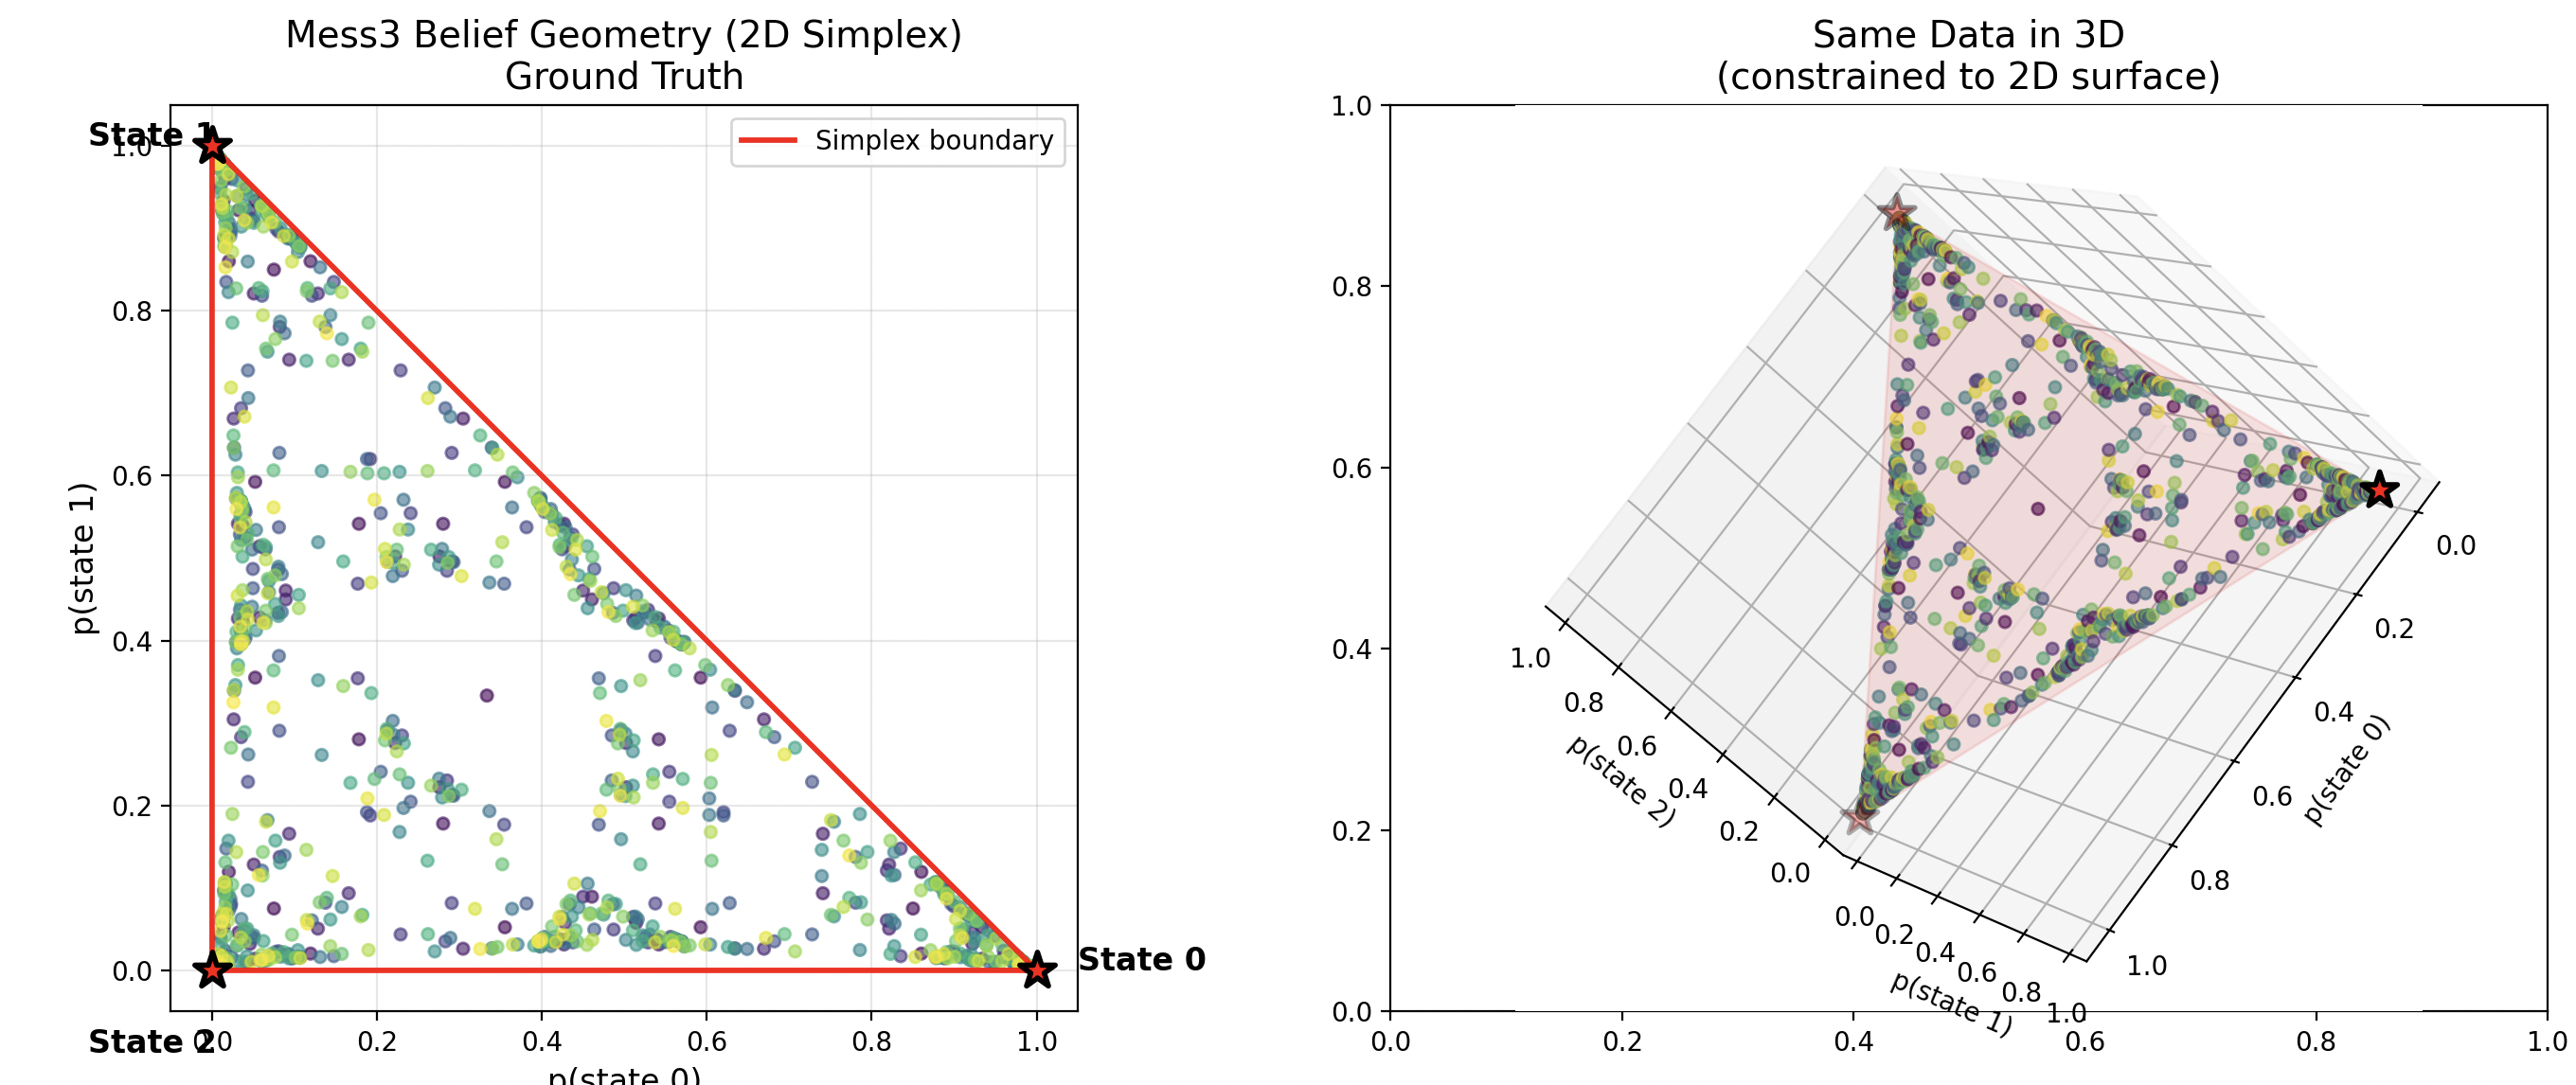

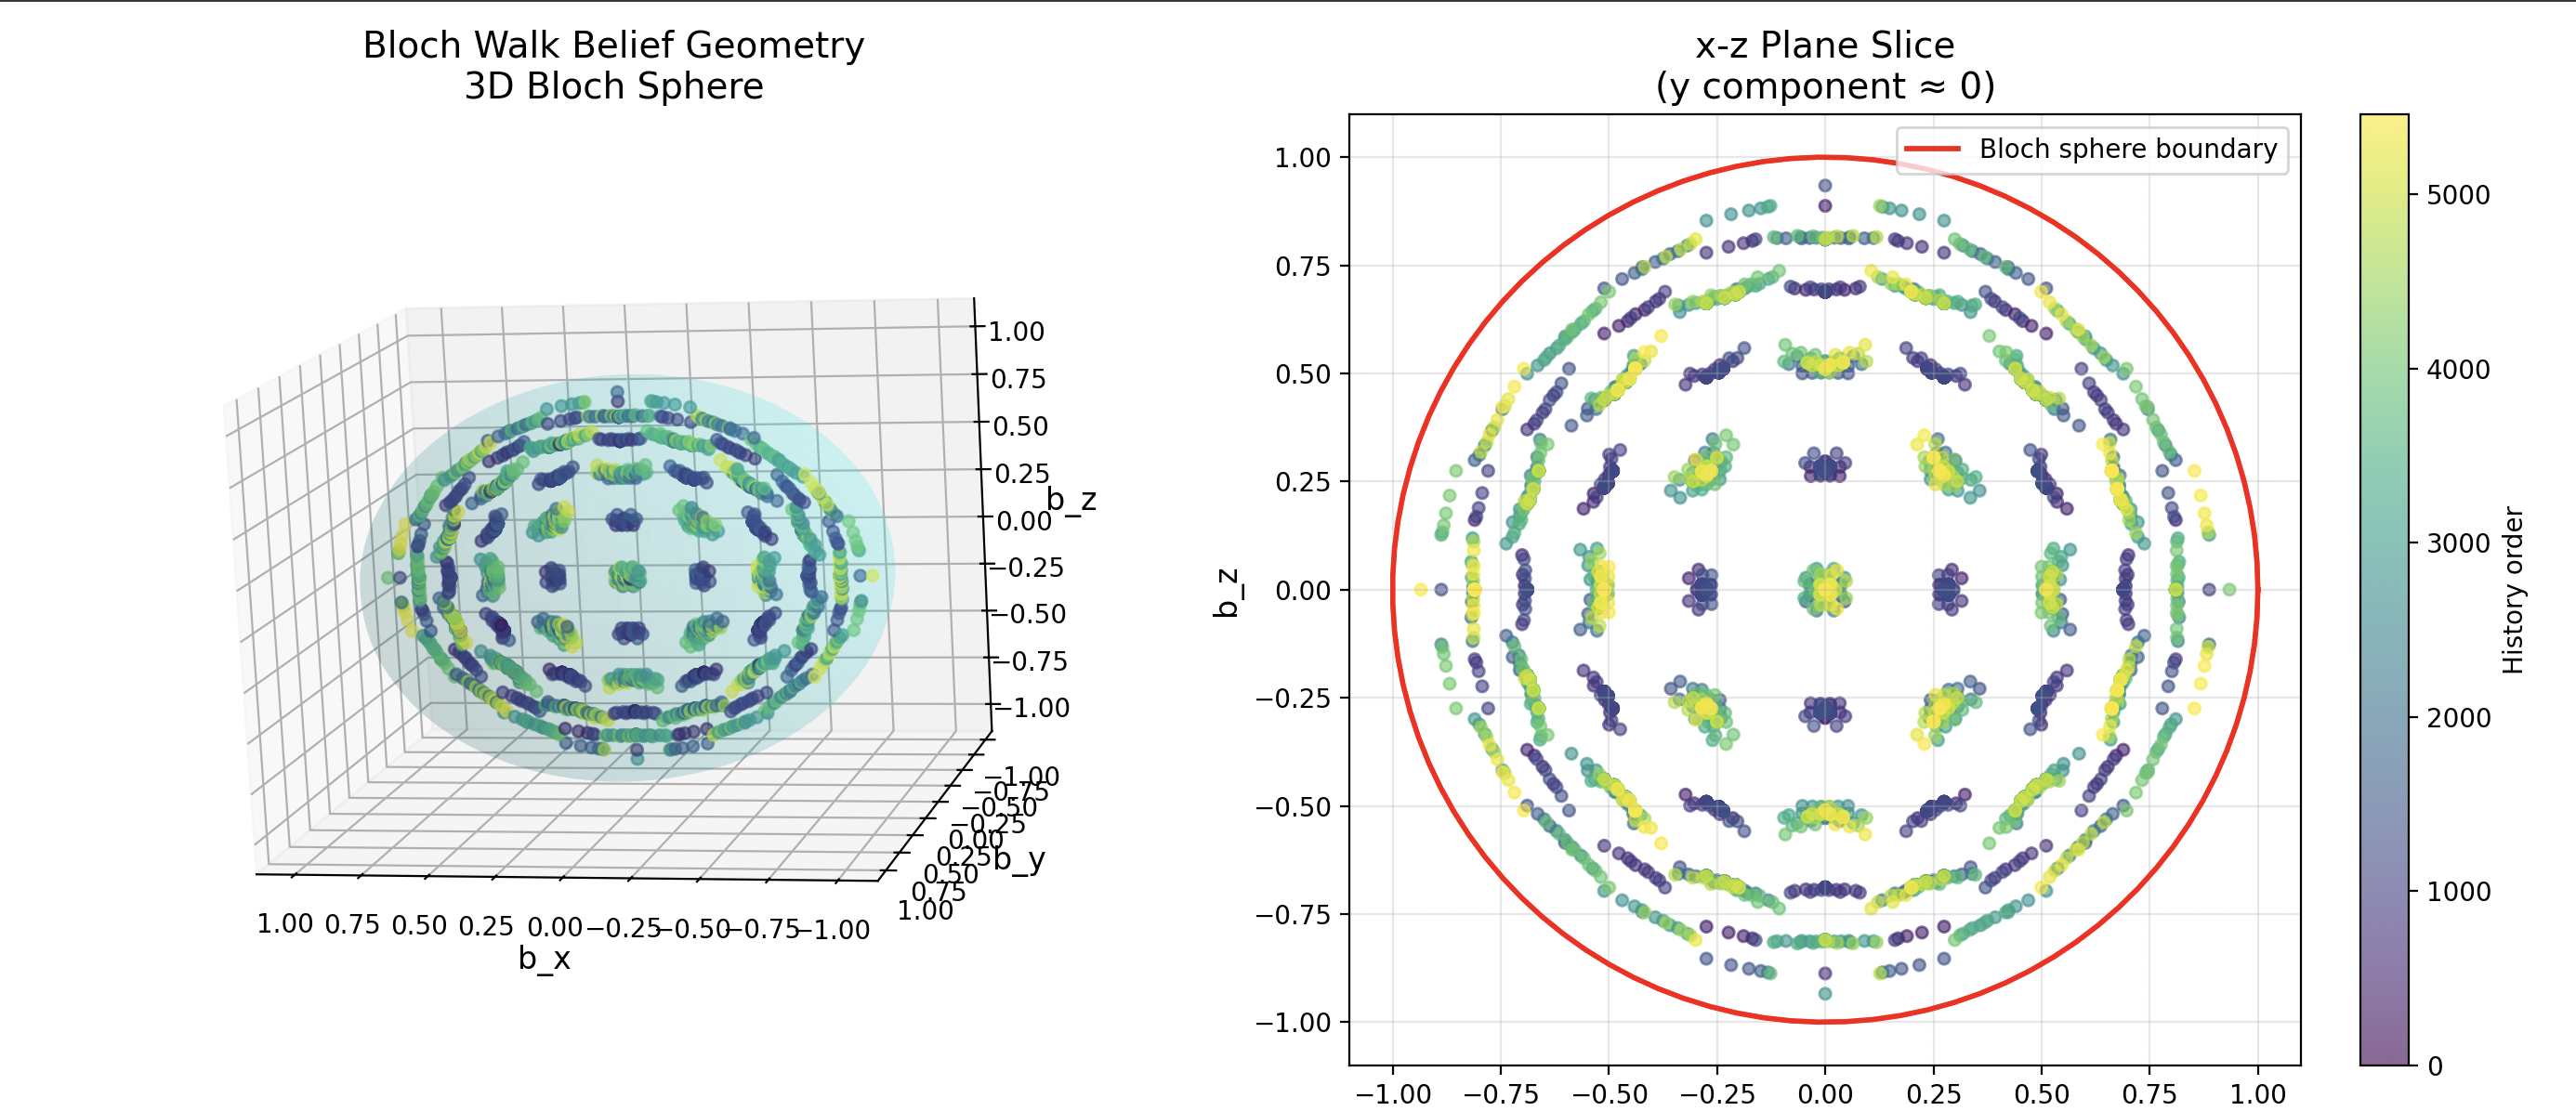

## 2. Interpretations

### Pre-Registered Prediction:

- Both the planes are going to collapse into a unique 2 dimensional plane in the activation layer
- I thought the both planes might intersect forming an R3 space
- Some kind of non-bijective correspondence between the both planes in R4

### Correct Interpretation:

Each degree of freedom corresponds to a dimension. All the dimensions must be represented inside the transformers because they're not compressible. Therefore the geometry has to be expressed in 4D.

- **Mess3 contributes**: 2 degrees of freedom (p0 + p1 + p2 = 1 e.g. p0, p1)
- **Bloch Walk contributes**: 2 degrees of freedom (bx² + by² + bz² ≤ 1 e.g. bx, bz)

The altitude-temperature analogy was very helpful for this to make sense to me. Just like you need separate dimensions for altitude and temperature (they're independent variables), you need separate dimensions for each process's belief state.

## 3. Implementation

### 3.1 Mess3 Process

Generates data that is the source of truth for 2D simplex by:

1. Defining the HMM by constructing a transition matrices T^(a), T^(b), T^(c) parameterized by α and β.
2. Samples token sequences {a, b, c}* from the process
3. Applies Bayesian filtering to each sequence history, updating the probability distribution over the 3 hidden states

**Key code snippet** - The transition matrices that define the process dynamics

In [1]:
# From mess3_process.py
def build_transition_matrices(self):
    """
    T^(x)[i,j] = Pr(next_state=j, observe_token=x | current_state=i)
    """
    α, β, x, y = self.alpha, self.beta, self.x, self.y
    
    self.T_a = np.array([
        [α*y, β*x, β*x],
        [α*x, β*y, β*x],
        [α*x, β*x, β*y]
    ])
    
    # Similarly for T_b and T_c...
    self.transition_matrices = [self.T_a, self.T_b, self.T_c]

**Bayesian filtering** - Computing belief states in order to form the ground truth simplex:

In [2]:
# From mess3_process.py
def compute_belief_state(self, token_history):
    """Bayesian filtering: belief_{t+1} = normalize(belief_t · T^(observed_token))"""
    belief = self.stationary_dist.copy()
    
    for token in token_history:
        # Bayesian update
        belief = belief @ self.transition_matrices[token]
        belief = belief / belief.sum()  # Normalize
    
    return belief  

### 3.2 Bloch Walk Process

The belief states live on a 2D slice through the Bloch ball, constrained to the x-z plane. We're doing essentially the same we did in the previous case:

1. Producing token observations {0,1,2,3} instead of {a,b,c}
2. Using Bayesian filtering (quantum version) to compute belief states

*See full implementation in `bloch_walk_process.py`*

**Key code snippet** - Kraus operators (quantum measurements, the equivalent to the transition matrixes we see in the simplex case):

In [3]:
# From bloch_walk_process.py
def build_kraus_operators(self):
    """K0-K3 represent quantum measurements that produce observable tokens 0-3"""
    α, β, γ = self.alpha, self.beta, self.gamma
    
    self.K0 = γ * (α * self.I + β * self.sigma_z)  # Reinforces +z
    self.K1 = γ * (α * self.I - β * self.sigma_z)  # Reinforces -z
    self.K2 = γ * (α * self.I + β * self.sigma_x)  # Reinforces +x
    self.K3 = γ * (α * self.I - β * self.sigma_x)  # Reinforces -x

**Quantum Bayesian update**: Calculating beliefs over quantum states (density matrices)

In [4]:
# From bloch_walk_process.py
def apply_kraus_operator(self, rho, token):
    """Quantum 'Bayesian update': ρ' = K_n ρ K_n† / Tr(K_n ρ K_n†)"""
    K = self.kraus_operators[token]
    new_rho_unnorm = K @ rho @ K.conj().T
    prob = np.real(np.trace(new_rho_unnorm))
    new_rho = new_rho_unnorm / prob
    return new_rho, prob

### 3.3 Composite Process

This simply uses the above processes to generate data, grouping tokens from both processes into a tuple.

*See full implementation in `composite_process.py`*

In [5]:
# From composite_process.py
def generate_sequence(self, length):
    """Generate via independent generation"""
    # Generate from Mess3 (classical HMM)
    mess3_tokens, mess3_states = self.mess3.generate_sequence(length)
    
    # Generate from Bloch Walk (quantum process)
    bloch_tokens, bloch_states = self.bloch.generate_sequence(length)
    
    # Combine into composite tokens
    composite_tokens = np.array([
        self.encode_composite_token(m, b)
        for m, b in zip(mess3_tokens, bloch_tokens)
    ])
    
    return composite_tokens, (mess3_states, bloch_states)

Token encoding: `composite_token = mess3_token * 4 + bloch_token`

This maps each (Mess3, Bloch) pair to a unique integer in {0, 1, ..., 11}.

### 3.4 Training the Transformer

#### Initial Attempt

**First model**: Ridge regression probe with 64 hidden dimensions, 2 layers
- Loss: **2.18**
- Training: 5000 steps
- **Problem**: Didn't capture non-linearities well
- Mess3 simplex represented underlying states though with high variance between states
- Bloch representation was very bad

<div style="column-gap:22px;">
  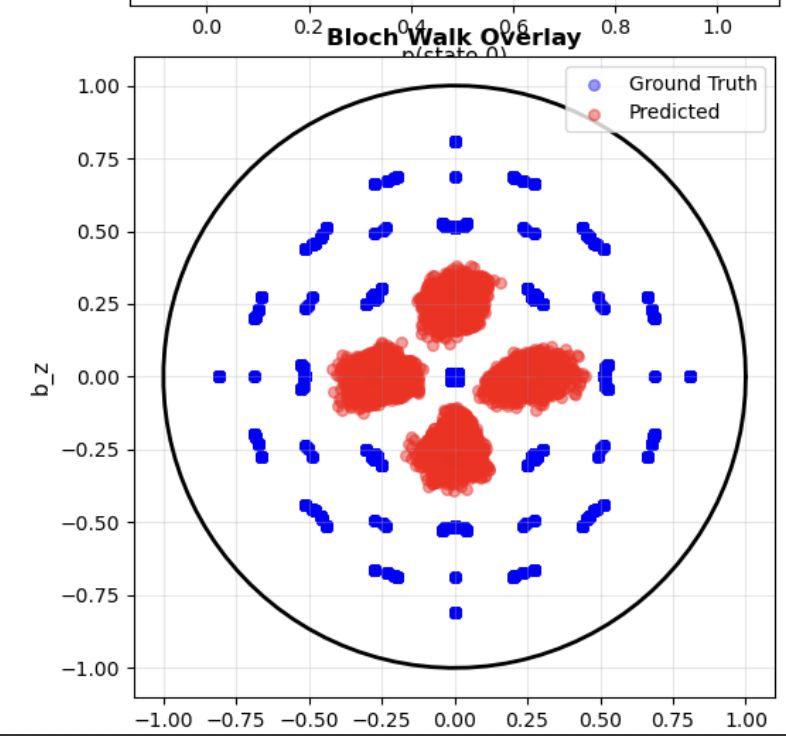
  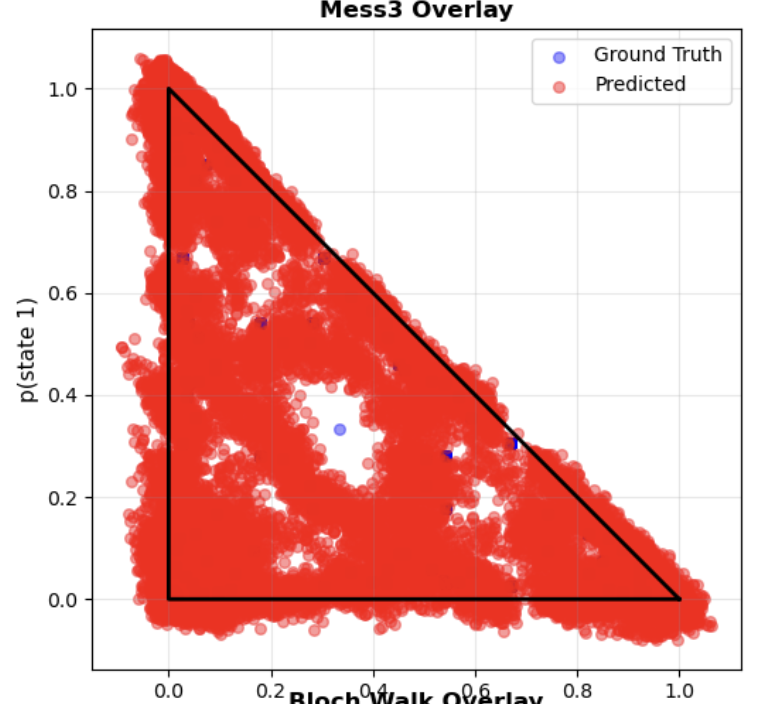
</div>


#### Scaling Up

**Second attempt**: 10x bigger model (~1M parameters)
- Added **MLP** for non-linearity (which I found out through reading the paper that was essential to Block)
- Increased to 15k steps
- Results were a little better, especially for the simplex with an MSE of 0.0113 (a really great improvement from the previous 0.0495). Though as we can observe from the image the improvement in the Bloch representation was way less significant.

<div style="column-gap:22px;">
  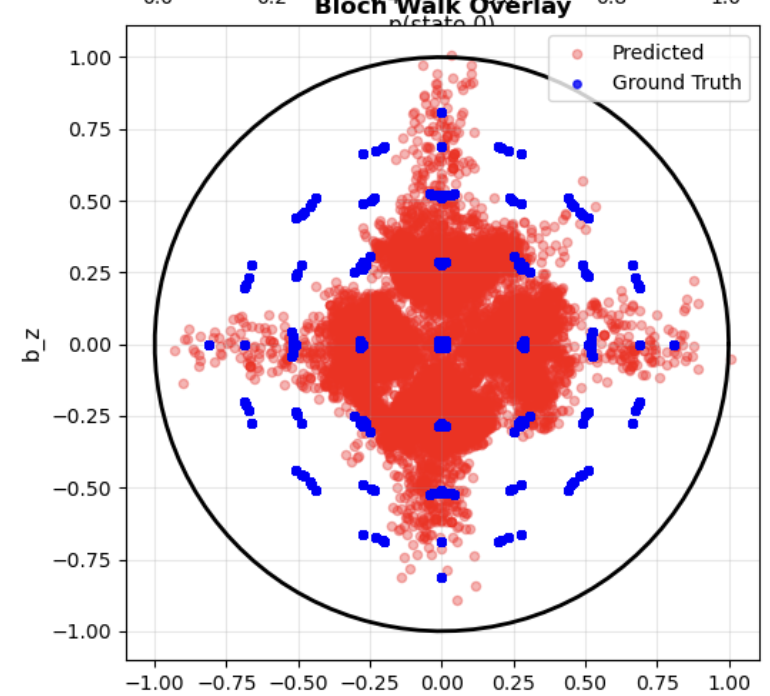
  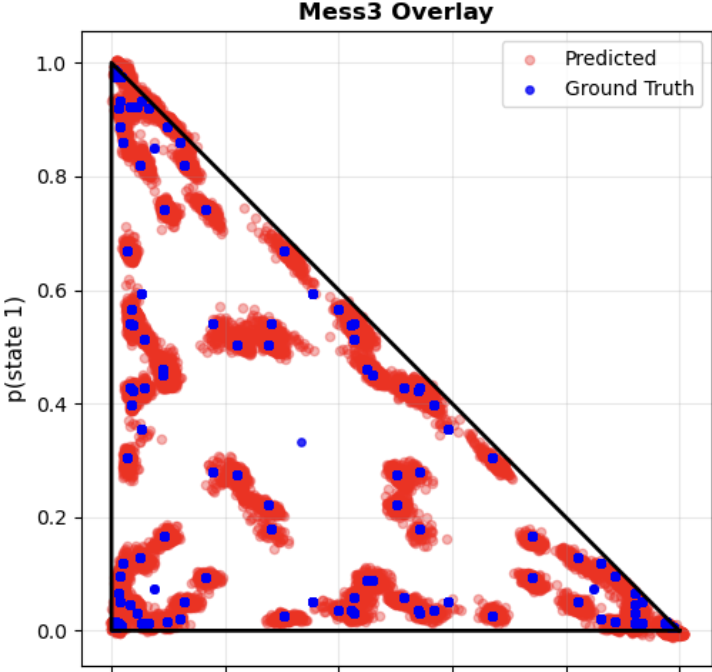
</div>


#### Padding in Llama

 When looking at probing results, I noticed my recovered geometries didn't have any points within certain regions.

I believe the reason for that is that the Llama model I was using as my transformer implementation uses token `0` for padding, but token `0` is also part of the language we're using to describe our observations.

**Solution**: 
```python
# Use pad_token=-1 (outside vocab 0-11) to distinguish from real tokens
padded = np.pad(tokens, (0, max_length - length), constant_values=-1)

# Then mask padding in labels with -100 (ignored by PyTorch loss)
labels[padding_mask] = -100
```

*See `train_transformer.py:85-145` for full padding implementation*

#### Adding Auxiliary Loss

Explicitly train the model to predict belief states with heads.

By adding auxiliary prediction heads that explicitly reconstruct the Mess3 and Bloch belief states from activations, we provide direct supervision for the model to preserve these geometric structures.

```python
# From train_transformer.py
# Mess3 belief predictor: D_MODEL -> 2 (first 2 simplex dims)
mess3_head = nn.Sequential(
    nn.Linear(D_MODEL, 64),
    nn.ReLU(),
    nn.Linear(64, 2)
)

# Bloch belief predictor: D_MODEL -> 3 (Bloch vector)
bloch_head = nn.Sequential(
    nn.Linear(D_MODEL, 64),
    nn.ReLU(),
    nn.Linear(64, 3)
)

# Combined loss
loss = next_token_loss + ALPHA * mess3_loss + BETA * bloch_loss
```

*See `train_transformer.py:188-356` for full auxiliary loss implementation*

**Result**: Significantly improved how the Bloch geometry appears in final activation layers. Yielding the best results I've encountered.

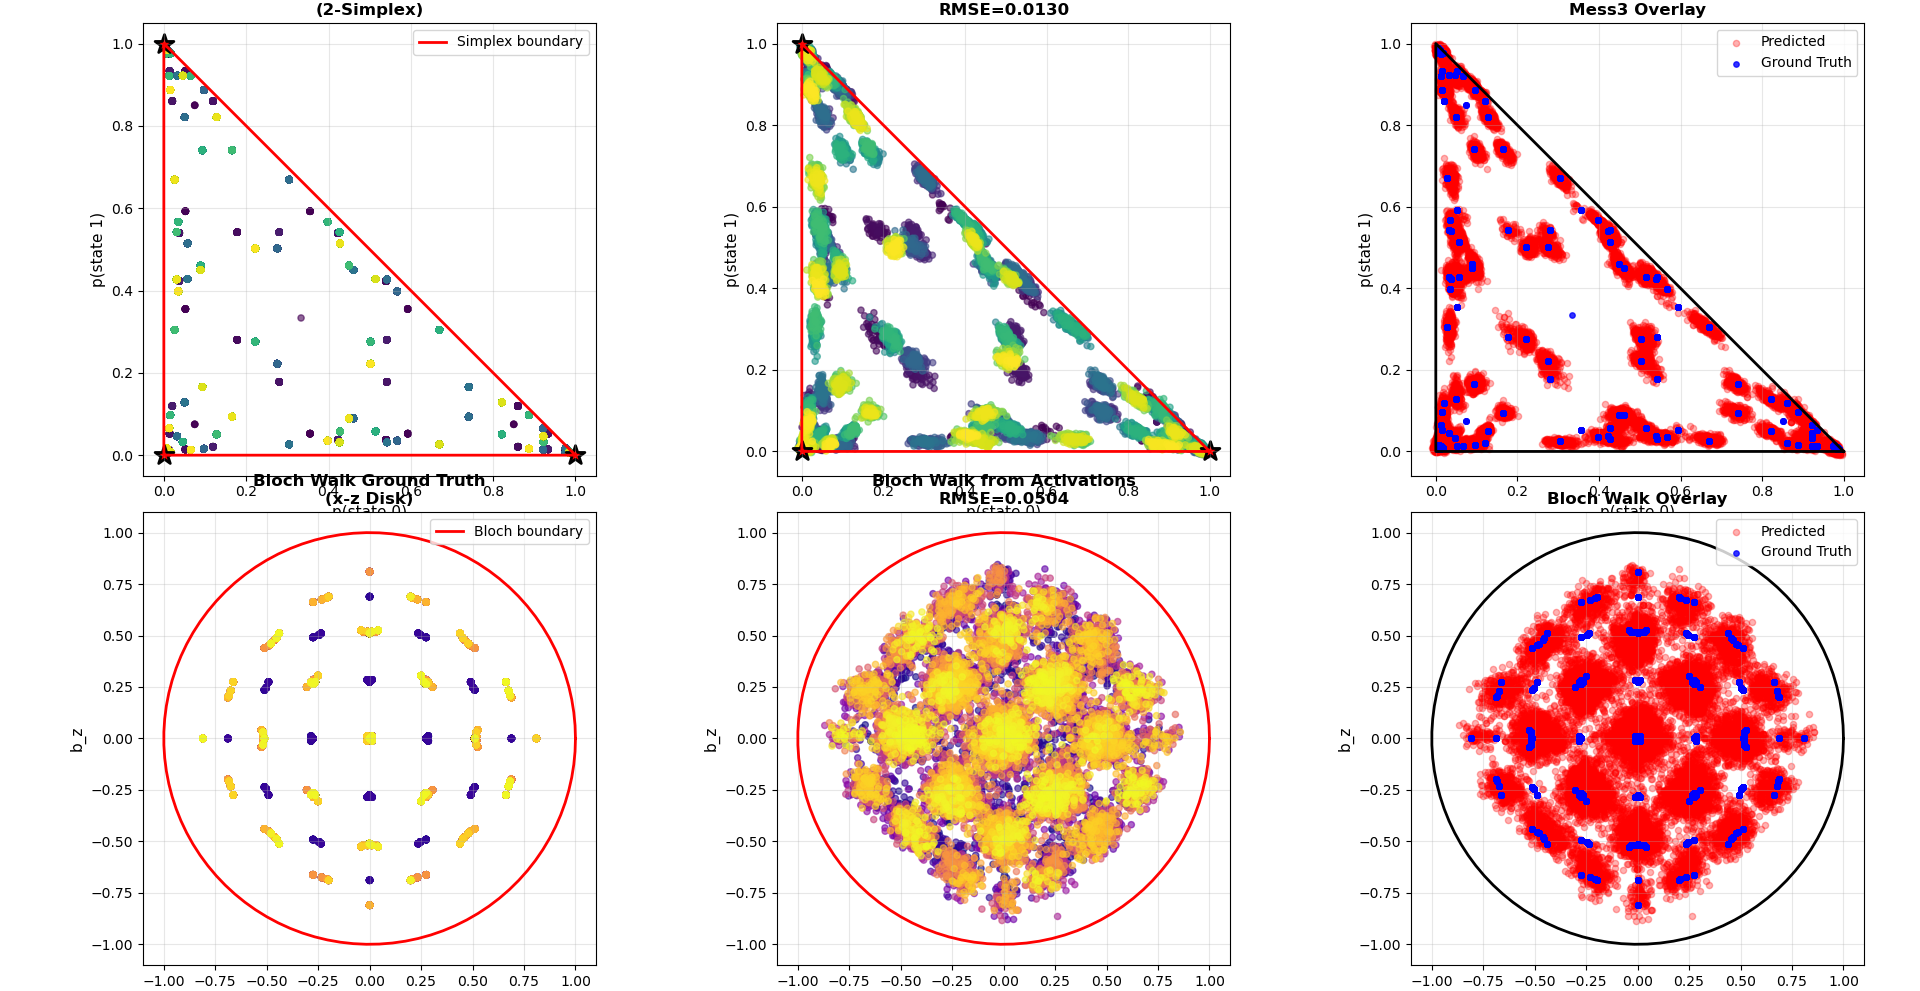

*See `train_transformer.py:38-79` for full hyperparameters*

### 3.5 Experiments With Negative or Neutral Results  

#### Context Length Experiments

**Hypothesis**: Increasing context from 8 to 16 might benefit Bloch states because they're more complex and need a longer context.

**Results**:
- Training: 25k steps (10k steps longer than I was training before)
- Best MSE: `mess3_aux=0.0004, bloch_aux=0.0365`

<div style="column-gap:22px;">
  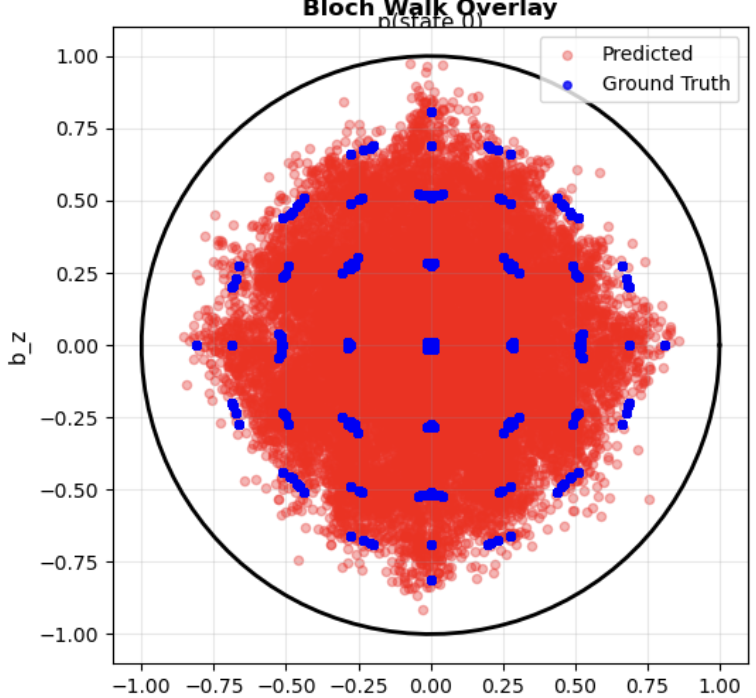
  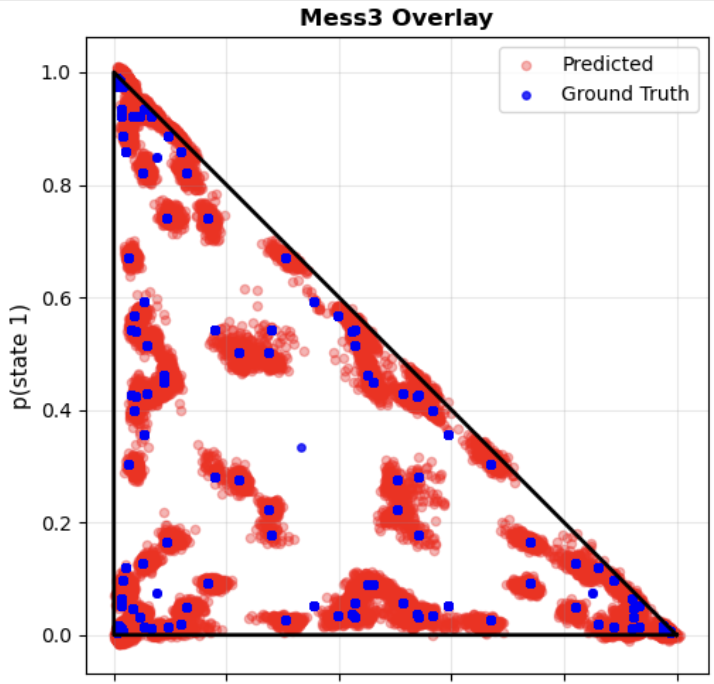
</div>

**Open question**: Why would longer context produce worse geometry? Need to investigate further.

#### Stochastic vs Deterministic Data

The transformer models cross-entropy loss were always around ~2.18. I was worried that this number was too high and it was the reason for the weak Bloch geometry recovery.

To test whether deterministic data could improve performance, we varied the ratio of stochastic to deterministic training sequences:

Data Mixing Experiments:
1. Fully deterministic: Severe overfitting
2. 75% stochastic / 25% deterministic: Loss = 2.16
3. 25% stochastic / 75% deterministic: Loss = 2.15

Result: Loss remained nearly constant (Δ = 0.01) across mixing ratios, provided some stochastic data is present. This confirmed that the loss plateau of ~2.15-2.19 reflects the intrinsic entropy of the stochastic processes, not model limitations.

#### Cosine Annealing Experiments

I noticed loss plateauing around similar values, so I tried:
```python
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=500, T_mult=1, eta_min=1e-5
)
```

Result: I noticed no difference between using cosine annealing and a simple scheduler.

### 3.6 Final Succesful Configuration

- **Architecture**: 4 layers, 128 hidden dim, 4 attention heads
- **Context**: 8 tokens
- **Training**: 15000 steps
- **Data**: Hybrid (25% fixed dataset, 75% fresh generation)
- **Auxiliary loss**: α=0.1 (Mess3), β=0.1 (Bloch)
- **No dropout** (model needs full capacity)

## 4. Probing the Activations

**Goal**: Extract activations from the residual stream and train probes to recover belief states.

**Approach**:
1. Generate all possible sequences up to length 4
2. Extract final layer activations for each sequence
3. Train MLP probes: `activations → belief_states`
4. Compare recovered geometry to ground truth

*See full implementation in `probe_activations.py`*

**Probe architecture**:

```python
# From probe_activations.py
# MLP probe for Mess3 (predicts first 2 simplex dimensions)
mess3_probe = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.2
)
mess3_probe.fit(activations, mess3_beliefs_gt[:, :2])

# Similar for Bloch (predicts 3D Bloch vector)
bloch_probe.fit(activations, bloch_beliefs_gt)
```

## 5. Conclusion

Are the individual geometries present?

Yes. Both geometries are successfully recovered from the transformer's final layer activations:

- Mess3 RMSE: 0.0011
- Bloch RMSE: 0.0226

The Mess3 simplex is recovered with high fidelity. The Bloch geometry shows slightly higher error, possibly due to quantum measurement stochasticity.

How are the geometries represented?

Three key findings from the 4D pairs plot:

1. Separability: Cross-correlation panels show stripe patterns, not structured correlations. For any Mess3 belief state, Bloch dimensions span their full range
independently. The processes remain disentangled.

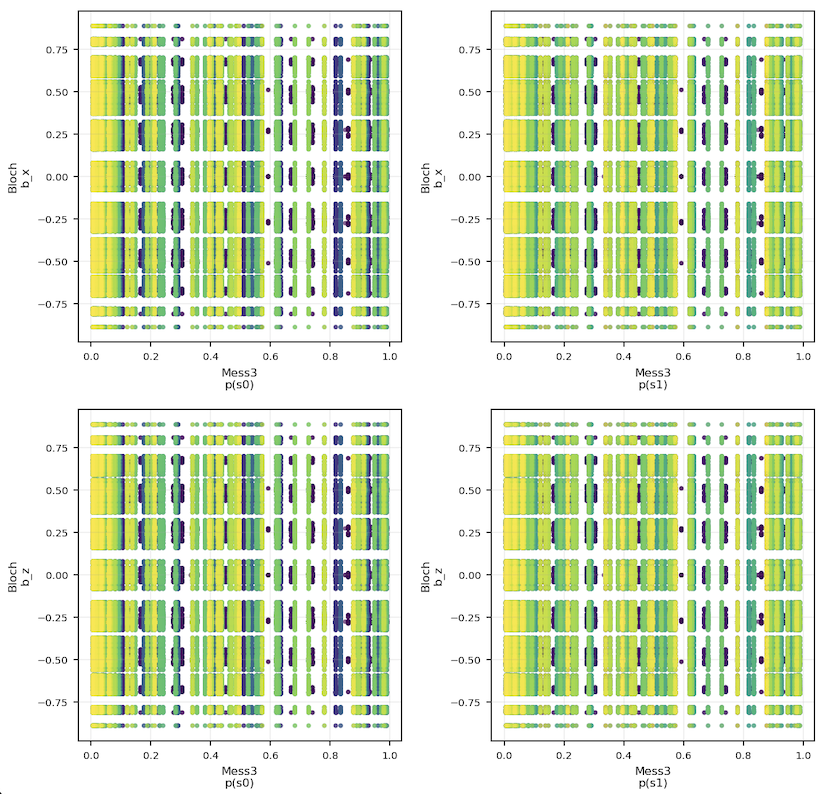

2. Minimal dimensionality: The representation uses exactly 4 dimensions (2 Mess3 + 2 Bloch), matching the theoretical minimum. No wasted dimensions on spurious
correlations.

2. Geometric preservation:
- Mess3 forms a 2-simplex
- Bloch forms a circular disk
- Both match theoretical belief geometries

Conclusion

The transformer learned a compositional, disentangled representation where independent stochastic processes remain independent in the residual stream. Auxiliary loss training successfully guided the model to discover the true factorization structure: 4D space = 2D Mess3 X 2D Bloch, with each geometry preserving its mathematical constraints.
